# Introduction

This lab will explore the Steiner tree problem, examining heuristics as well as optimal solution methods.

First, import required packages.

In [610]:
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import treeopt
import numpy as np
from scipy.spatial import Delaunay

from networkx.algorithms import approximation

import gurobipy as gp
from gurobipy import GRB
import pandas as pd

# Generating a Random Graph

Next, set some parameters related to how we will construct the graph.

In [611]:
num_vertices = 12
#num_terminals = 5
distance_max = 0.55
np.random.seed(41)

To ensure that the solutions to the Steiner Tree Problem are not trivial, I manually added edges and manually changed some edge weights.

In [612]:
edges_to_add = [(0,3)]
weights_to_change = {}

Next, we randomly generate points and use the Delaunay triangulation to ensure that the graph is *planar* (i.e., the edges to not cross over each other).

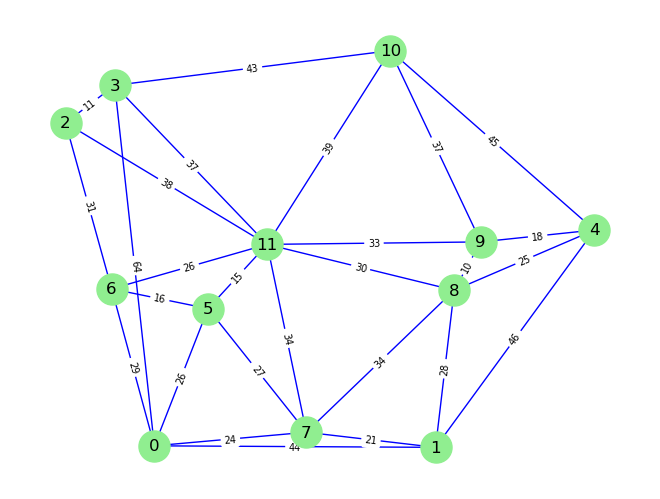

In [613]:
points = np.random.rand(num_vertices, 2)

# Compute the Delaunay triangulation of these points
tri = Delaunay(points)

G = nx.Graph()
G.add_nodes_from(range(num_vertices))

for i in range(num_vertices):
    G.nodes[i]['pos'] = points[i]

def get_distance(u, v):
    return 1 + 100*np.linalg.norm(points[u] - points[v])

# For every triangle (simplex), add edges between its vertices
for simplex in tri.simplices:
    for i in range(len(simplex)):
        for j in range(i + 1, len(simplex)):
            u, v = simplex[i], simplex[j]
            #distance = 1 + 100*np.linalg.norm(points[u] - points[v])
            G.add_edge(u, v, weight=get_distance(u, v))


# Remove some edges that have a distance longer than distance_max
for edge in list(G.edges()):
    distance = np.linalg.norm(points[edge[0]] - points[edge[1]])
    if distance > distance_max:
        G.remove_edge(*edge)

for (i,j) in edges_to_add:
    distance = 1 + 100*np.linalg.norm(points[i] - points[j])
    G.add_edge(i,j, weight=distance)

for edge in weights_to_change:
    if G.has_edge(*edge):
        G[edge[0]][edge[1]]['weight'] = weights_to_change[edge]
        
pos = {i: G.nodes[i]['pos'] for i in G.nodes()}

nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color='blue', node_size=500)

edge_labels = nx.get_edge_attributes(G, 'weight')
rounded_edge_labels = {edge: int(round(G[edge[0]][edge[1]]['weight'], 0)) for edge in G.edges()}

def draw_edge_labels(G : nx.Graph):
    rounded_edge_labels = {edge: int(round(G[edge[0]][edge[1]]['weight'], 0)) for edge in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=rounded_edge_labels, font_size=7)

draw_edge_labels(G)

plt.show()

This code writes this graph as a LaTeX ``tikzpicture``.

In [614]:
treeopt.graph_to_latex(G, scale = 10, edge_labels = rounded_edge_labels, edge_label_align = "near start",
                       tikz_file_name = f"img/graph{num_vertices}.tex")

# Minimum Spanning Tree

In [615]:
# Find the minimum spanning tree using an algorithm built in to networkx.
mst = nx.minimum_spanning_tree(G)

total_weight = sum(G[u][v]['weight'] for u, v in mst.edges())
print("Total weight of the minimum spanning tree:", total_weight)

Total weight of the minimum spanning tree: 237.1855065180219


Then we display the MST solution on the graph.

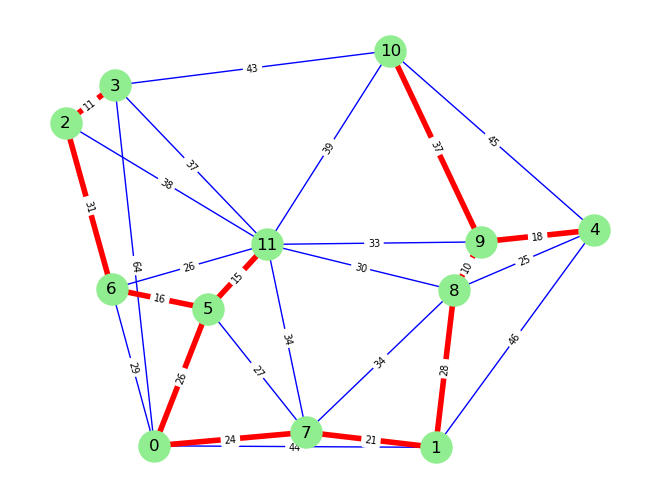

In [616]:
# Set edge attributes for MST edges

def get_edge_colors(G, edges_list):
    for u, v in G.edges():
        if (u,v) in edges_list or (v,u) in edges_list:
            G[u][v]['color'] = 'red'
        else:
            G[u][v]['color'] = 'blue'

    return ['red' if G[u][v].get('color') == 'red' else 'blue' for u, v in G.edges()]

def get_edge_widths(G, edges_list):
    for u, v in G.edges():
        if (u,v) in edges_list or (v,u) in edges_list:
            G[u][v]['width'] = 4.0
        else:
            G[u][v]['width'] = 1.0

    return [G[u][v]['width'] for u, v in G.edges()]

# Draw the graph with MST edges in red and thicker
nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color=get_edge_colors(G, mst.edges()), 
        width = get_edge_widths(G, mst.edges()), node_size=500)

draw_edge_labels(G)

plt.show()

Again, the following code writes this graph as a LaTeX ``tikzpicture``.

In [617]:
edge_opts = {e: treeopt.get_edge_style(e, mst.edges()) for e in G.edges}

treeopt.graph_to_latex(G, scale = 10, edge_labels = rounded_edge_labels, edge_opts=edge_opts,
                       tikz_file_name = f"img/mst{num_vertices}.tex")

## Metric Closure

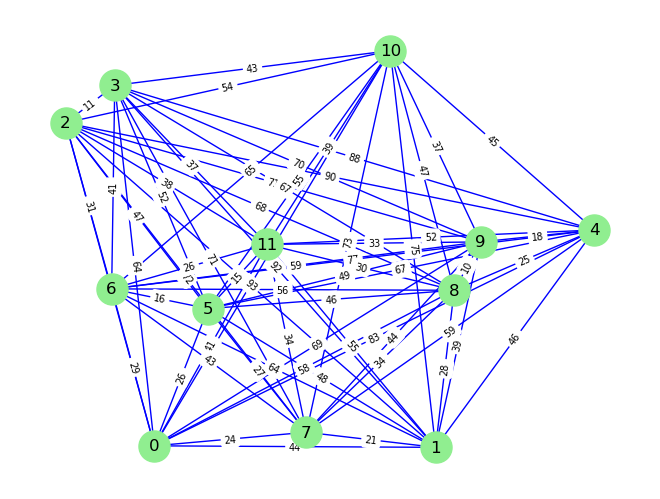

In [618]:
metric_closure_graph = approximation.metric_closure(G)
for i in range(num_vertices):
    metric_closure_graph.nodes[i]['pos'] = points[i]

for u, v in metric_closure_graph.edges():
    metric_closure_graph[u][v]['weight'] = metric_closure_graph[u][v]['distance']

nx.draw(metric_closure_graph, pos, with_labels=True, node_color='lightgreen', edge_color='blue', node_size=500)

draw_edge_labels(metric_closure_graph)

plt.show()

In [619]:
rounded_closure_edge_labels = {edge: int(round(metric_closure_graph[edge[0]][edge[1]]['weight'], 0)) 
                               for edge in metric_closure_graph.edges()}
treeopt.graph_to_latex(metric_closure_graph, scale = 10, edge_labels = rounded_closure_edge_labels, 
                       edge_label_align = "near start",
                       tikz_file_name = f"img/metric-closure-{num_vertices}.tex")

MST in metric closure.

Total weight of the minimum spanning tree of the metric closure graph: 237.19


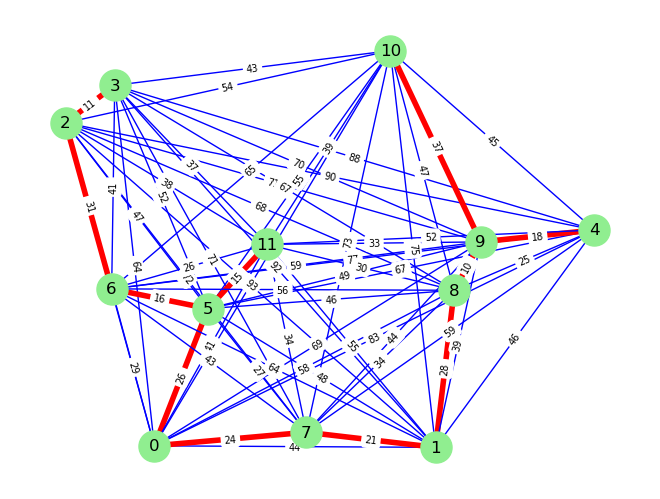

In [620]:
mst = nx.minimum_spanning_tree(metric_closure_graph)
for i in range(num_vertices):
    mst.nodes[i]['pos'] = points[i]

rounded_cost = round(sum(metric_closure_graph[u][v]['weight'] for u, v in mst.edges()), 2)
print("Total weight of the minimum spanning tree of the metric closure graph:", rounded_cost)
nx.draw(metric_closure_graph, pos, with_labels=True, node_color='lightgreen', 
        edge_color=get_edge_colors(metric_closure_graph, mst.edges()), 
        width = get_edge_widths(metric_closure_graph, mst.edges()), node_size=500)

draw_edge_labels(metric_closure_graph)

plt.show()

In [621]:
edge_opts = {e: treeopt.get_edge_style(e, mst.edges()) for e in metric_closure_graph.edges}

treeopt.graph_to_latex(metric_closure_graph, scale = 10, edge_labels = rounded_closure_edge_labels, edge_opts=edge_opts,
                       edge_label_align = "near start",
                       tikz_file_name = f"img/metric-closure-mst{num_vertices}.tex")

Draw only the MST edges.

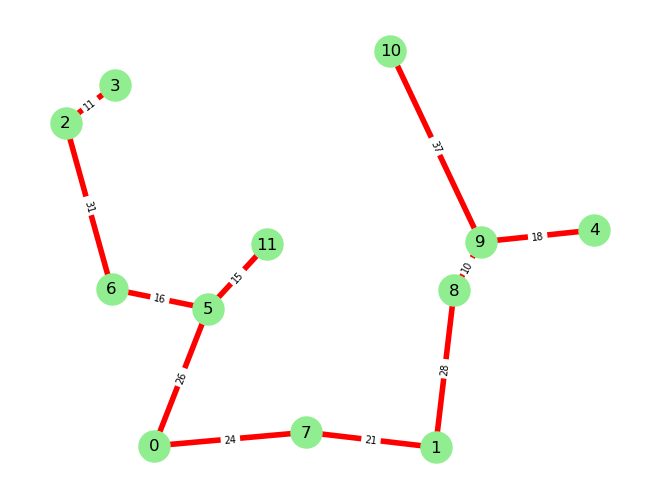

In [622]:
nx.draw(mst, pos, with_labels=True, node_color='lightgreen', 
        edge_color=get_edge_colors(mst, mst.edges()), 
        width = get_edge_widths(mst, mst.edges()), node_size=500)

draw_edge_labels(mst)

plt.show()

In [623]:
edge_opts = {e: treeopt.get_edge_style(e, mst.edges()) for e in mst.edges}

treeopt.graph_to_latex(mst, scale = 10, edge_labels = rounded_edge_labels, edge_opts=edge_opts,
                       edge_label_align = "near start",
                       tikz_file_name = f"img/metric-closure-mst-only{num_vertices}.tex")

odd degree nodes: [3, 4, 5, 9, 10, 11]


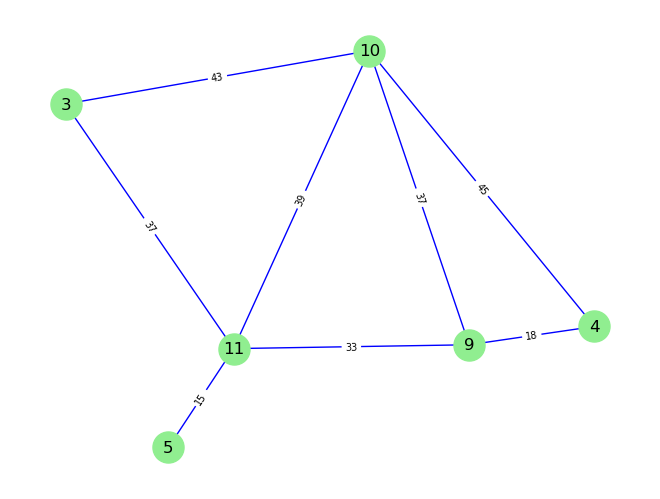

In [624]:
# Step 1: Get nodes with odd degree in the MST
odd_degree_nodes = [node for node, degree in mst.degree() if degree % 2 != 0]
print("odd degree nodes:", odd_degree_nodes)
# Step 2: Create subgraph with nodes of odd degree
odd_degree_subgraph = G.subgraph(odd_degree_nodes)

nx.draw(odd_degree_subgraph, pos, with_labels=True, node_color='lightgreen', edge_color='blue', node_size=500)

draw_edge_labels(odd_degree_subgraph)

plt.show()

In [625]:
rounded_closure_edge_labels = {edge: int(round(odd_degree_subgraph[edge[0]][edge[1]]['weight'], 0)) 
                               for edge in odd_degree_subgraph.edges()}
treeopt.graph_to_latex(odd_degree_subgraph, scale = 10, edge_labels = rounded_closure_edge_labels, 
                       edge_label_align = "near start",
                       tikz_file_name = f"img/odd-degree-subgraph-{num_vertices}.tex")

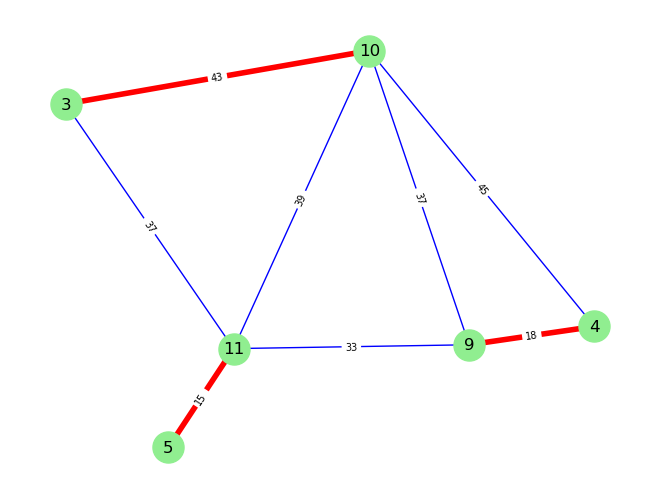

In [626]:
matching = nx.algorithms.matching.min_weight_matching(odd_degree_subgraph)

edge_colors = ['red' if (u,v) in matching else 'blue' for u, v in odd_degree_subgraph.edges()]
edge_widths = [4.0 if (u,v) in matching else 1.0 for u, v in odd_degree_subgraph.edges()]
nx.draw(odd_degree_subgraph, pos, with_labels=True, node_color='lightgreen', 
        edge_color=edge_colors, width = edge_widths, node_size=500)
draw_edge_labels(odd_degree_subgraph)
plt.show()

In [627]:
edge_opts = {e: treeopt.get_edge_style(e, matching) for e in odd_degree_subgraph.edges}

treeopt.graph_to_latex(odd_degree_subgraph, scale = 10, edge_labels = rounded_edge_labels, edge_opts=edge_opts,
                       edge_label_align = "near start",
                       tikz_file_name = f"img/matching-{num_vertices}.tex")

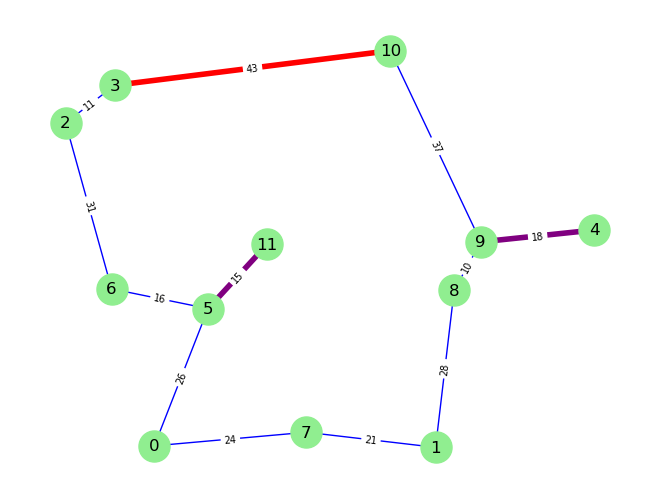

In [628]:
eulerian_multigraph = nx.MultiGraph(mst)
eulerian_multigraph.add_edges_from(matching)
for u,v in eulerian_multigraph.edges():
    if 'weight' not in eulerian_multigraph[u][v][0]:
        eulerian_multigraph[u][v][0]['weight'] = G[u][v]['weight']

eulerian_graph = nx.Graph(eulerian_multigraph)

edge_added = [(u,v) for u, v in eulerian_graph.edges() if (u,v) in matching and (u,v) not in mst.edges()]
edge_in_both = [(u,v) for u, v in eulerian_graph.edges() if (u,v) in matching and (u,v) in mst.edges()]

def get_color(u, v):
    if (u,v) in edge_added:
        return 'red'
    elif (u,v) in edge_in_both:
        return 'purple'
    else:
        return 'blue'
    
def get_width(u, v):
    if (u,v) in edge_added or (u,v) in edge_in_both:
        return 4.0
    else:
        return 1.0
    
edge_colors = [get_color(u, v) for u, v in eulerian_graph.edges()]
edge_widths = [get_width(u, v) for u, v in eulerian_graph.edges()]

nx.draw(eulerian_graph, pos, with_labels=True, node_color='lightgreen', 
        edge_color=edge_colors, width = edge_widths, node_size=500)

rounded_edge_labels = {(u,v): int(round(eulerian_graph[u][v]['weight'], 0)) for u,v in eulerian_graph.edges()}
nx.draw_networkx_edge_labels(eulerian_graph, pos, edge_labels=rounded_edge_labels, font_size=7)

plt.show()


In [629]:
def get_edge_style(e, E1, E2):
    if (e[0], e[1]) in E1 or (e[1], e[0]) in E1:
        return "selected_edge_style"
    elif (e[0], e[1]) in E2 or (e[1], e[0]) in E2:
        return "selected_edge_style-2"
    else:
        return "edge_style"

edge_opts = {e: get_edge_style(e, edge_added, edge_in_both) for e in eulerian_graph.edges}

treeopt.graph_to_latex(eulerian_graph, scale = 10, edge_labels = rounded_edge_labels, edge_opts=edge_opts,
                       edge_label_align = "near start",
                       tikz_file_name = f"img/eulerian-graph-{num_vertices}.tex")

In [630]:
# Step 5: Find an Eulerian circuit
eulerian_circuit = list(nx.eulerian_circuit(eulerian_multigraph))
rounded_cost = round(sum(eulerian_graph[u][v]['weight'] for u, v in eulerian_circuit), 2)
print("Total weight of the Eulerian circuit:", rounded_cost)

Total weight of the Eulerian circuit: 313.93


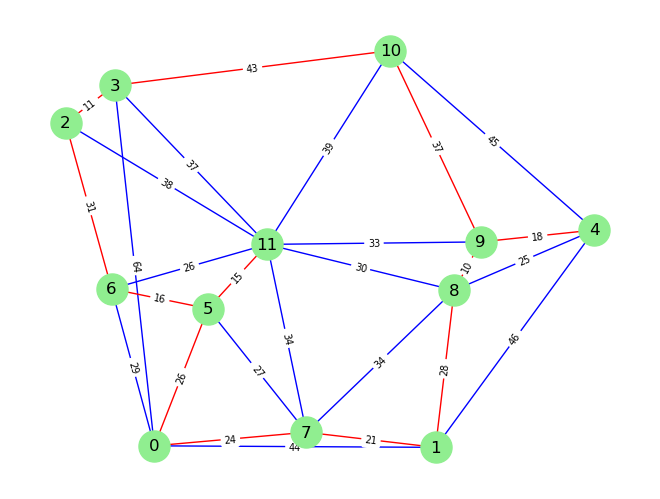

In [631]:
nx.draw(G, pos, with_labels=True, node_color='lightgreen', 
        edge_color=get_edge_colors(G, eulerian_graph.edges()), width = 1.0, node_size=500)

rounded_edge_labels = {(u,v): int(round(G[u][v]['weight'], 0)) for u,v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=rounded_edge_labels, font_size=7)

plt.show()

In [632]:
edge_opts = {e: treeopt.get_edge_style(e, eulerian_graph.edges()) for e in G.edges}

treeopt.graph_to_latex(G, scale = 10, edge_labels = rounded_edge_labels, edge_opts=edge_opts,
                       edge_label_align = "near start",
                       tikz_file_name = f"img/eulerian-circuit-{num_vertices}.tex")

Cost of the TSP tour: 304.51


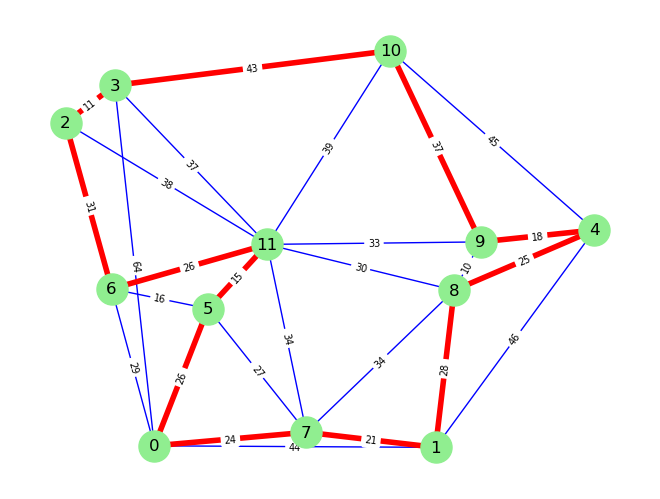

In [633]:
# Step 6: Shortcutting to form the final TSP tour
tsp_tour = []
visited = set()
for u, v in eulerian_circuit:
    if u not in visited:
        tsp_tour.append(u)
        visited.add(u)
tsp_tour.append(tsp_tour[0])  # Return to starting point
edges_list = [(tsp_tour[i], tsp_tour[i + 1]) for i in range(len(tsp_tour) - 1)]

rounded_cost = round(sum(G[u][v]['weight'] for u, v in edges_list), 2)
print("Cost of the TSP tour:", rounded_cost)

nx.draw(G, pos, with_labels=True, node_color='lightgreen', 
        edge_color=get_edge_colors(G, edges_list), 
        width = get_edge_widths(G, edges_list), node_size=500)

draw_edge_labels(G)

plt.show()

In [634]:
edge_opts = {e: treeopt.get_edge_style(e, edges_list) for e in G.edges}

treeopt.graph_to_latex(G, scale = 10, edge_labels = rounded_edge_labels, edge_opts=edge_opts,
                       edge_label_align = "near start",
                       tikz_file_name = f"img/tsp-tour-christofides-{num_vertices}.tex")

# Heuristic Solutions

Because the TSP is NP-hard, we next examine several heuristics for solving it.

## Christofides

Cost of the TSP tour using Christofides' algorithm: 304.51


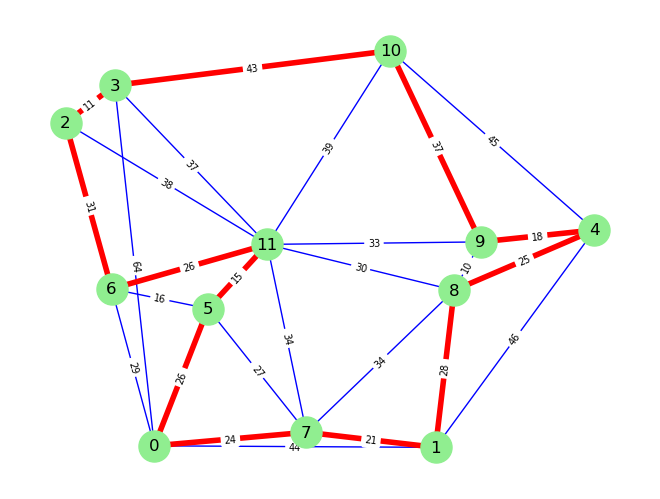

In [635]:
tsp = approximation.traveling_salesman_problem
cycle=True
path = tsp(G, cycle=cycle, method=nx.approximation.christofides)
edge_list = list(zip(path, path[1:]))
if not cycle:
     edge_list += [(path[-1], path[0])]
rounded_cost = round(sum(G[u][v]['weight'] for u, v in edge_list), 2)
print("Cost of the TSP tour using Christofides' algorithm:", rounded_cost)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', 
        edge_color=get_edge_colors(G, edge_list), width = get_edge_widths(G, edge_list), node_size=500)

draw_edge_labels(G)

plt.show()


And we then write the graph as a ``tikzpicture``.

## Greedy (Cheapest Arc)

[0, 7, 1, 8, 9, 4, 10, 11, 5, 6, 2, 3, 0]
Cost of the TSP tour using Greedy algorithm: 321.97


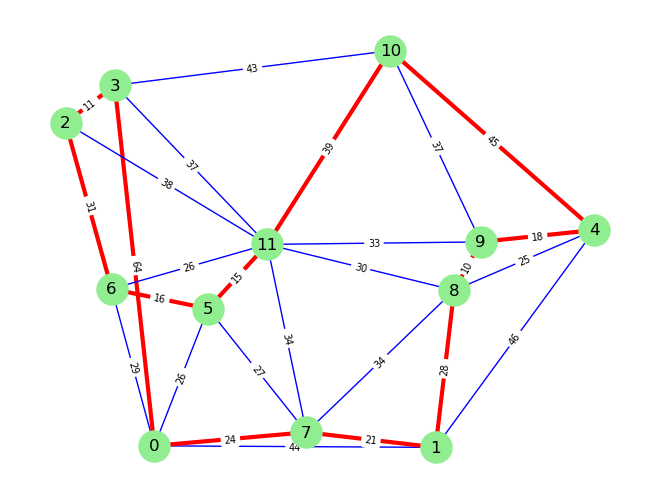

In [636]:
cycle = True
path = tsp(G, cycle=cycle, method=nx.approximation.greedy_tsp)
print(path)
edge_list = list(zip(path, path[1:]))
if not cycle:
    edge_list.append((path[-1], path[0]))
rounded_cost = round(sum(G[u][v]['weight'] for u, v in edge_list), 2)
print("Cost of the TSP tour using Greedy algorithm:", rounded_cost)
for u, v in G.edges():
    if (u,v) in edge_list or (v,u) in edge_list:
        G[u][v]['color'] = 'red'
        G[u][v]['width'] = 3.0
    else:
        G[u][v]['color'] = 'blue'
        G[u][v]['width'] = 1.0

edge_colors = ['red' if G[u][v].get('color') == 'red' else 'blue' for u, v in G.edges()]
widths = [G[u][v]['width'] for u, v in G.edges()]

# Draw the graph with MST edges in red and thicker
nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color=edge_colors, width = widths, node_size=500)

draw_edge_labels(G)

plt.show()


Here we display the solution on the graph and export as ``tikzpicture``.

In [637]:
edge_opts = {e: treeopt.get_edge_style(e, edges_list) for e in G.edges}

treeopt.graph_to_latex(G, scale = 10, edge_labels = rounded_edge_labels, edge_opts=edge_opts,
                       edge_label_align = "near start",
                       tikz_file_name = f"img/tsp-tour-greedy-{num_vertices}.tex")

# Exact Methods



## Integer Programming

In [638]:
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum

m = gp.Model("TSP-depot")
nodes = list(G.nodes())
depot = 0

x = m.addVars(nodes, nodes, name="x", vtype=GRB.BINARY)
u = m.addVars(nodes, name="u")

m.setObjective(qsum(get_distance(i,j)*x[i, j] for i in nodes for j in nodes),
            GRB.MINIMIZE)

m.addConstrs((qsum(x[i,h] for h in nodes if h != i) == 1 for i in nodes), 
            name="Out")

m.addConstrs((qsum(x[h,i] for h in nodes if h != i) == 1 for i in nodes), 
            name="In")

m.addConstrs((u[i] - u[j] + len(nodes) * x[i, j] <= len(nodes) - 1 
            for i in nodes for j in nodes if i != depot and j != depot), 
            name="Subtour")

# Optimize the model
m.optimize()

# Print the optimal cost of the tour
optimal_cost = m.objVal
print("Optimal cost of the tour:", round(optimal_cost, 2))

# Get the tour as a list of vertices
tour = [0]
current_vertex = 0
while True:
    for v in G.neighbors(current_vertex):
        if x[current_vertex, v].x > 0.5:
            tour.append(v)
            current_vertex = v
            break
    if current_vertex == 0:
        break

print("Tour:", tour)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 24.0.0 24A335)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 145 rows, 156 columns and 605 nonzeros
Model fingerprint: 0x6557e356
Variable types: 12 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 11 rows and 13 columns
Presolve time: 0.00s
Presolved: 134 rows, 143 columns, 594 nonzeros
Variable types: 11 continuous, 132 integer (132 binary)

Root relaxation: objective 2.666937e+02, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  266.69366    0   20          -  266.69366      -     -    0s
H    0     0       

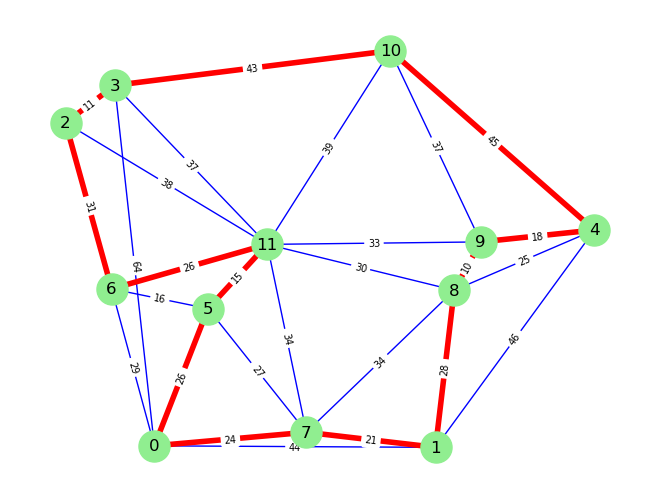

In [639]:
edge_list = list(zip(tour, tour[1:]))
rounded_cost = round(sum(G[u][v]['weight'] for u, v in edge_list), 2)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', 
        edge_color=get_edge_colors(G, edge_list), width = get_edge_widths(G, edge_list), node_size=500)

draw_edge_labels(G)

plt.show()

In [640]:
edge_opts = {e: treeopt.get_edge_style(e, edges_list) for e in G.edges}

treeopt.graph_to_latex(G, scale = 10, edge_labels = rounded_edge_labels, edge_opts=edge_opts,
                       edge_label_align = "near start",
                       tikz_file_name = f"img/tsp-tour-optimal-{num_vertices}.tex")